In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

In [10]:
random_stat = 123

storage_client = storage.Client(project = 'ih-final-project-277919')

bucket = storage_client.get_bucket("data_images_ih")

SIZE = 416 #p1
#SIZE = 608 #open images


In [52]:
!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

Cloning into 'darknet'...
remote: Enumerating objects: 5904, done.
remote: Total 5904 (delta 0), reused 0 (delta 0), pack-reused 5904
Receiving objects: 100% (5904/5904), 6.33 MiB | 0 bytes/s, done.
Resolving deltas: 100% (3925/3925), done.
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~


In [11]:
DATA_PATH = '/home/jupyter/data/'

#TRAIN_PATH = os.path.join(DATA_PATH, "train_images")
#TEST_PATH = os.path.join(DATA_PATH, "test_images")

FRAME_PATH = os.path.join(os.getcwd(), 'images')  # .jpg
MASK_PATH = os.path.join(os.getcwd(), 'labels')  # .txt
METADATA_PATH = os.path.join(os.getcwd(), 'metadata') # .txt

# YOLOv3 config file directory
CONFIG_PATH = os.path.join(os.getcwd(), 'cfg')
# YOLOv3 training checkpoints will be saved here
BACKUP_PATH = os.path.join(os.getcwd(), 'backup')

for directory in [FRAME_PATH, MASK_PATH, METADATA_PATH, CONFIG_PATH, BACKUP_PATH ]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [12]:
colnames=['LabelName','Label']
df_class = pd.read_csv(f'{DATA_PATH}/class-descriptions-boxable.csv',names=colnames, header=None)

In [13]:
df_class.head()

,LabelName,Label
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [14]:
annots = pd.read_csv(f'{DATA_PATH}/df_all_data.csv')
annots.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,25e3acb1a25707dd,train,https://c6.staticflickr.com/8/7659/17891339551...,https://www.flickr.com/photos/archiefalkmaar/1...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/archiefalkmaar/,Regionaal Archief Alkmaar,Vrijwilligersuitje 2015,2677536,FvIDdDhff45GCENbR2CXuQ==,...,0,0,0.715000,0.766875,0.999375,0.390625,0.438149,0.999056,0.885741,0.915958
1,9aaa4a4bce049a85,train,https://farm6.staticflickr.com/8164/7388947910...,https://www.flickr.com/photos/45131642@N00/738...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/45131642@N00/,Phil Parker,Decks and Boats in,28624,8Jqvyk2WuArDznavCtpBnA==,...,1,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,6db5e012cf2936fa,train,https://c3.staticflickr.com/3/2874/9062318686_...,https://www.flickr.com/photos/atgeist/9062318686,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/atgeist/,TownePost Network,Cocktail Cove cuties get the party started,5036881,6Rn5G58CFybS6b1wUeTApg==,...,0,0,0.975000,0.999375,0.780625,0.037500,0.381341,0.456522,0.999094,0.999094
3,6db5e012cf2936fa,train,https://c3.staticflickr.com/3/2874/9062318686_...,https://www.flickr.com/photos/atgeist/9062318686,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/atgeist/,TownePost Network,Cocktail Cove cuties get the party started,5036881,6Rn5G58CFybS6b1wUeTApg==,...,0,0,0.690000,0.231250,0.185000,0.700000,0.241848,0.395833,0.494565,0.259058
4,6db5e012cf2936fa,train,https://c3.staticflickr.com/3/2874/9062318686_...,https://www.flickr.com/photos/atgeist/9062318686,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/atgeist/,TownePost Network,Cocktail Cove cuties get the party started,5036881,6Rn5G58CFybS6b1wUeTApg==,...,0,0,0.766875,0.265625,0.337500,0.778125,0.210145,0.455616,0.526268,0.368659


In [15]:
annots.shape

(79113, 32)

In [16]:
annots = annots.merge(df_class, left_on = 'LabelName', right_on ='LabelName')

In [17]:
annots.drop_duplicates(inplace=True)

In [18]:
annots.shape

(79113, 33)

In [19]:
annots.columns

Index(['ImageID', 'Subset', 'OriginalURL', 'OriginalLandingURL', 'License',
       'AuthorProfileURL', 'Author', 'Title', 'OriginalSize', 'OriginalMD5',
       'Thumbnail300KURL', 'Rotation', 'Source', 'LabelName', 'Confidence',
       'XMin', 'XMax', 'YMin', 'YMax', 'IsOccluded', 'IsTruncated',
       'IsGroupOf', 'IsDepiction', 'IsInside', 'XClick1X', 'XClick2X',
       'XClick3X', 'XClick4X', 'XClick1Y', 'XClick2Y', 'XClick3Y', 'XClick4Y',
       'Label'],
      dtype='object')

In [20]:
annots_masks = annots[['ImageID','XMin', 'XMax', 'YMin', 'YMax','Label','Confidence']]
annots_masks.head()

,ImageID,XMin,XMax,YMin,YMax,Label,Confidence
0,25e3acb1a25707dd,0.390625,0.999375,0.438149,0.999056,Boat,1
1,9aaa4a4bce049a85,0.015919,0.946454,0.096610,0.901695,Boat,1
2,6db5e012cf2936fa,0.037500,0.999375,0.381341,0.999094,Boat,1
3,6db5e012cf2936fa,0.185000,0.700000,0.241848,0.494565,Boat,1
4,6db5e012cf2936fa,0.265625,0.778125,0.210145,0.526268,Boat,1


In [21]:
def save_label(MASK_PATH, image_id, row=None):
    
    if os.path.isfile(os.path.join(MASK_PATH, "{}.txt".format(image_id)))==True:
            return
    else:

        label_fp = os.path.join(MASK_PATH, "{}.txt".format(image_id))

        f = open(label_fp, "a")
        if row is None:
            f.close()
            return

        XMin = row[1]
        XMax = row[2]
        YMin = row[3]
        YMax = row[4]
        label = row[5]
        label = 0 #as we only have one class we use 0

        rw = (XMax - XMin)
        rh = (YMax - YMin)
        rcx = XMin + rw/2
        rcy = YMin + rh/2

        line = "{} {} {} {} {}\n".format(label, rcx, rcy, rw, rh)

        f.write(line)
        f.close()

In [22]:
def save_image(FRAME_PATH, image_id, image_blob, dim):
    
    
    try:
        if os.path.isfile(os.path.join(FRAME_PATH, "{}.jpg".format(image_id)))==True:
            return
        else:
            img_fp = os.path.join(FRAME_PATH, "{}.jpg".format(image_id))
            image = np.asarray(bytearray(image_blob.download_as_string()), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
            resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

            if len(resized_image.shape) == 2:
                resized_image = cv2.cvtColor(resized_image,cv2.COLOR_GRAY2RGB)

            cv2.imwrite(img_fp, resized_image)
    except:
        #images missing that we won't add to the model

        return image_id

In [23]:
for row in tqdm(annots_masks.values):
        image_id = row[0]
        save_label(MASK_PATH, image_id, row)

100%|██████████| 79113/79113 [00:02<00:00, 33868.75it/s]


In [24]:
image_annots = annots[['ImageID','OriginalURL']]
#image_annots.loc[:,'OriginalURL'] = image_annots.loc[:,'OriginalURL'].apply(lambda x: x.replace('https://',''))

image_annots['OriginalURL'] = image_annots['OriginalURL'].str.replace('https://','')

image_annots.drop_duplicates(inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
#image_annots.head()

In [26]:
images = 100

In [27]:
WIDTH = SIZE
HEIGHT = SIZE
dim = (WIDTH, HEIGHT)

not_images =[]

for row in tqdm(image_annots.values[:images]):
        image_id = row[0]
        image_blob = bucket.blob(row[1])
        not_img = save_image(FRAME_PATH, image_id,image_blob,dim)
        
        not_images.append(not_img)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


In [28]:
not_images_2 = [x for x in not_images if x is not None]

In [29]:
len(not_images_2)

7

In [30]:
image_annots = image_annots[~image_annots['ImageID'].isin(not_images_2)][:(images-len(not_images_2)-10)]

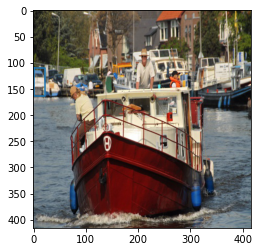

In [31]:
ex_image_id = image_annots.ImageID.values[80]
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
ex_label_path = os.path.join(MASK_PATH, "{}.txt".format(ex_image_id))

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
    
with open(ex_label_path, "r") as f:
    for line in f:
        x = line.strip().split()
        class_name  = x[0]
        rcx, rcy, rw, rh = [float(i) for i in x[1:]]
        x = (rcx-rw/2)*dim[0]
        y = (rcy-rh/2)*dim[1]
        w = rw*dim[0]
        h = rh*dim[1]
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [32]:
def write_train_list(METADATA_PATH, FRAME_PATH, name, series):
    list_fp = os.path.join(METADATA_PATH, name)

    with open(list_fp, "w") as f:
        for image_id in series:
            line = "{}\n".format(os.path.join(FRAME_PATH, "{}.jpg".format(image_id)))
            f.write(line)

In [33]:
image_annots.shape

(83, 2)

In [34]:
tr_series, val_test_series = train_test_split(image_annots['ImageID'], test_size=0.2, random_state=random_stat)
test_series, val_series = train_test_split(val_test_series, test_size=0.5, random_state=random_stat)

print(f'The # of train set: {tr_series.shape[0]}, The # of validation set: {val_series.shape[0]} \
The # of test set: {test_series.shape[0]}')

# train image path list
write_train_list(METADATA_PATH, FRAME_PATH, "tr_list.txt", tr_series)
# validation image path list
write_train_list(METADATA_PATH, FRAME_PATH, "val_list.txt", val_series)
# test image path list
write_train_list(METADATA_PATH, FRAME_PATH, "test_list.txt", test_series)

The # of train set: 66, The # of validation set: 9 The # of test set: 8


In [35]:
#Esto no funciona pero tampoco se para que sirve si ya tenemos la metadata con trin y validation lists (paths imagenes)

#La idea es crear test images. Se puede mirar luego

In [36]:
data_extention_file_path = os.path.join(CONFIG_PATH, 'p1.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(METADATA_PATH, "tr_list.txt"),
               os.path.join(METADATA_PATH, "val_list.txt"),
               os.path.join(CONFIG_PATH, 'p1.names'),
               BACKUP_PATH)
    f.write(contents)

In [37]:
!cat cfg/p1.data

classes= 1
train  = /home/jupyter/.local/share/Trash/files/metadata/tr_list.txt
valid  = /home/jupyter/.local/share/Trash/files/metadata/val_list.txt
names  = /home/jupyter/.local/share/Trash/files/cfg/p1.names
backup = /home/jupyter/.local/share/Trash/files/backup
    

In [38]:
!echo "boat" > cfg/p1.names

In [53]:
!cd darknet

In [54]:
print(dim)

(416, 416)


In [55]:

print(f'Images are: {dim}')
      
#!./darknet_gpu detector train cfg/p1.data cfg/yolov3-open1.cfg darknet53.conv.74 -i 0 | tee train_log_open.txt

!./darknet_gpu detector train cfg/p1.data cfg/yolov3-p1.cfg darknet53.conv.74 -i 0 | tee train_log_p1.txt

Images are: (416, 416)
Couldn't open file: cfg/yolov3-p1.cfg
yolov3-p1


Text(0, 0.5, 'Loss')

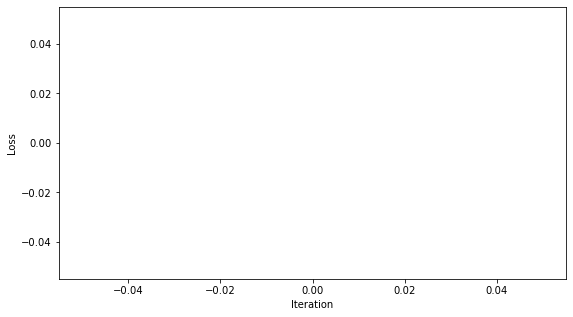

In [56]:
iters = []
losses = []
total_losses = []
with open("train_log_p1.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [43]:
import shutil

In [44]:
ex_image_id = annots.ImageID.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_image_id)

6db5e012cf2936fa


In [45]:
!ls -alsth backup

total 8.0K
4.0K drwx------ 24 jupyter jupyter 4.0K May 29 15:59 ..
4.0K drwxr-xr-x  2 jupyter jupyter 4.0K May 28 08:17 .


In [46]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

In [47]:
!cd darknet && ./darknet detector test ../cfg/p1.data ../cfg/yolov3-p1.cfg_test ../backup/yolov3-p1_300.weights ../test.jpg -thresh 0.005

/bin/sh: 1: cd: can't cd to darknet


In [48]:
![](predictions.jpg)

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


In [49]:
#plt.imshow(cv2.imread("./darknet/predictions.jpg"))

In [50]:
from ctypes import *
import os

In [51]:
lib = CDLL("./darknet/libdarknet.so", RTLD_GLOBAL)
darknet_lib_path = os.path.join(os.getcwd(), "darknet", "libdarknet.so")
lib = CDLL(darknet_lib_path, RTLD_GLOBAL)

OSError: ./darknet/libdarknet.so: cannot open shared object file: No such file or directory

In [ ]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

In [ ]:
from darknet import *

In [ ]:
threshold = 0.2

In [ ]:
submit_file_path = "submission.csv"
cfg_path = os.path.join(CONFIG_PATH, "yolov3-p1.cfg")
weight_path = os.path.join(BACKUP_PATH, "yolov3-p1_final.weights")

test_img_list_path = os.path.join(METADATA_PATH, "test_list.txt")

In [ ]:
load_net = lib.load_network
load_meta = lib.get_metadata
load_image = lib.load_image_color

In [ ]:
gpu_index = 0
net = load_net(cfg_path.encode(),
               weight_path.encode(), 
               gpu_index)

In [ ]:
meta = load_meta(data_extention_file_path.encode())

In [ ]:
submit_dict = {"ImageId": [], "PredictionString": []}

with open(test_img_list_path, "r") as test_img_list_f:
    # tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        image_id = line.strip().split('/')[-1].strip().split('.')[0]
        print(image_id)
        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)
        print(infer_result)
        submit_line = ""
        for e in infer_result:
            confi = e[1]
            w = e[2][2]
            h = e[2][3]
            x = e[2][0]-w/2
            y = e[2][1]-h/2
            submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)
        print(submit_line)
        submit_dict["ImageId"].append(image_id)
        submit_dict["PredictionString"].append(submit_line)

pd.DataFrame(submit_dict).to_csv(submit_file_path, index=False)

In [ ]:
# !ls -lsht
#!rm -rf darknet images labels metadata backup cfg
#!rm -rf train_log.txt darknet53.conv.74 darknet.py darknet_gpu
#!rm -rf test.jpg
#!rm -rf __pycache__ .ipynb_checkpoints

In [ ]:
#!ls -alsht